# A forward model of earthquake surface displacements using okapy

Comparing downsampled InSAR data with model predictions, calculating penalties and residuals...

## Initialize some things

We'll start with an optional install...

In [11]:
pip install okada_wrapper  # if you haven't already installed it

Note: you may need to restart the kernel to use updated packages.


...by importing some dependencies...

In [1]:
from okapy import rect_shear_fault
from math import sin, cos, tan, radians
from matplotlib import cm, colors
import numpy as np
import matplotlib.pyplot as plt

...and also importing some downsampled InSAR data. (While we're at it, we should convert the coordinates to meters.)

In [3]:
!ls ../../preparing_insar/prepareInSARdata

README.md		   elazig_asc_ll.okinv
elazig_asc.okinv	   process_quadtree_output.ipynb
elazig_asc_kite_scene.npz  quadtree_decomposition_kite.ipynb
elazig_asc_kite_scene.yml


In [4]:
data = np.loadtxt('../../preparing_insar/prepareInSARdata/elazig_asc.okinv', delimiter=' ')  # make sure you have the correct path to the file for your system
data[:,0]*=1000  # convert x coord from km to m
data[:,1]*=1000  # convert y coord from km to m

In [5]:
data

array([[ 4.65143042e+05,  4.19773851e+06,  2.21810000e-02, ...,
         1.13046000e-01, -7.44379000e-01,  1.00000000e+00],
       [ 4.74953186e+05,  4.19804466e+06,  2.74800000e-02, ...,
         1.13496000e-01, -7.37700000e-01,  2.00000000e+00],
       [ 4.64206284e+05,  4.21260839e+06,  1.80530000e-02, ...,
         1.13115000e-01, -7.43042000e-01,  3.00000000e+00],
       ...,
       [ 5.00514773e+05,  4.36478972e+06,  7.63390000e-02, ...,
         1.14103000e-01, -7.03204000e-01,  1.92000000e+02],
       [ 5.11672271e+05,  4.35400866e+06,  6.72780000e-02, ...,
         1.14151000e-01, -6.98028000e-01,  1.93000000e+02],
       [ 5.11260882e+05,  4.36559589e+06,  7.44320000e-02, ...,
         1.14207000e-01, -6.96345000e-01,  1.94000000e+02]])

Now let's set up some numbers

In [16]:
# a vector of fault parameters: strike, dip, rake, slip, x, y, length, top, bottom
fparams = np.array([60, 90, 5, 2, 495000, 4238000, 25000, 4000, 12000]) # all values in degrees or m

# a vector of elastic parameters
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Run the model!

Now we can run the Okada model. This version, part of 'okapy.py', takes in the fault parameters, elastic parameters and data as inputs and returns the line-of-sight displacements at the locations of the data points as an output. It uses the unit line-of-sight vector components provided in the 4th, 5th and 6th columns of the data array to project the 3D displacements of the Okada model into 1D radar line-of-sight. 

In [17]:
model_los_disps = rect_shear_fault(fparams, eparams, data)

Let's plot the data and forward models, so that we can compare them: 

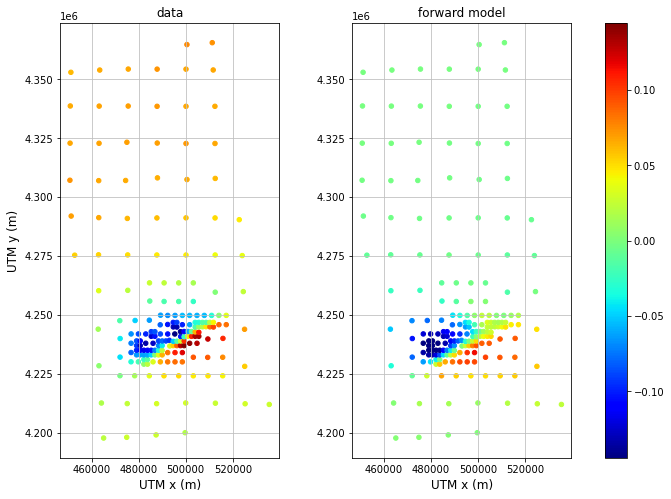

In [18]:
# estimate color limits
cmin, cmax = data[:,2].min(), data[:,2].max()

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,8))
axlist = [ax1,ax2]   # handles for your subplots


# scatter with colormap mapping to z value
scat=ax1.scatter(data[:,0],data[:,1],s=20,c=data[:,2], marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax1.set_xlabel("UTM x (m)",fontsize=12)
ax1.set_ylabel("UTM y (m)",fontsize=12)
ax1.title.set_text('data')
ax1.grid(True,linestyle='-',color='0.75')
ax1.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax2.scatter(data[:,0],data[:,1],s=20,c=model_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax2.set_xlabel("UTM x (m)",fontsize=12)
ax2.title.set_text('forward model')
ax2.grid(True,linestyle='-',color='0.75')
ax2.set_aspect('equal')

fig.colorbar(scat,ax=axlist)

plt.show();

## Of penalties and residuals

We can assess the goodness of fit by calculating a penalty function. Typically we use the total squared misfit, which is i) always a positive number, and ii) related to the lognormal probability that the model fits the data (which is useful for Bayesian statistics...)

In [19]:
penalty = np.sum(np.square(data[:,2]-model_los_disps))
print('total squared penalty:',penalty,'m^2')

total squared penalty: 0.43330538791246775 m^2


We might also want to account for a 'nuisance parameter', the unknown zero level of the data, when estimating misfit. This arises because the zero level in an unwrapped interferogram is usually chosen arbitraily, and may not be a location which experienced zero displacement; it could also be affected by noise. This can affect every single datapoint, and so can have a very large effect on the misfit. We can account for this by computing the mean of the residuals (the differences between the data and the modeled displacements) and subtracting it from the data when calculating the penalty.

In [20]:
# calculate the mean residual
zero_shift = np.mean(data[:,2]-model_los_disps)
print('zero level shift:',zero_shift,'m')

# now subtract this from the data when computing the misfit
penalty = np.sum(np.square((data[:,2]-zero_shift)-model_los_disps))
print('total squared penalty:',penalty,'m^2')

zero level shift: 0.01974779473951941 m
total squared penalty: 0.35765016088007484 m^2


The residuals are also useful for identifying where your model fits well and where it doesn't. Really, you ought to plot them along with your data and model (and account for the zero shift in the data when you do it).

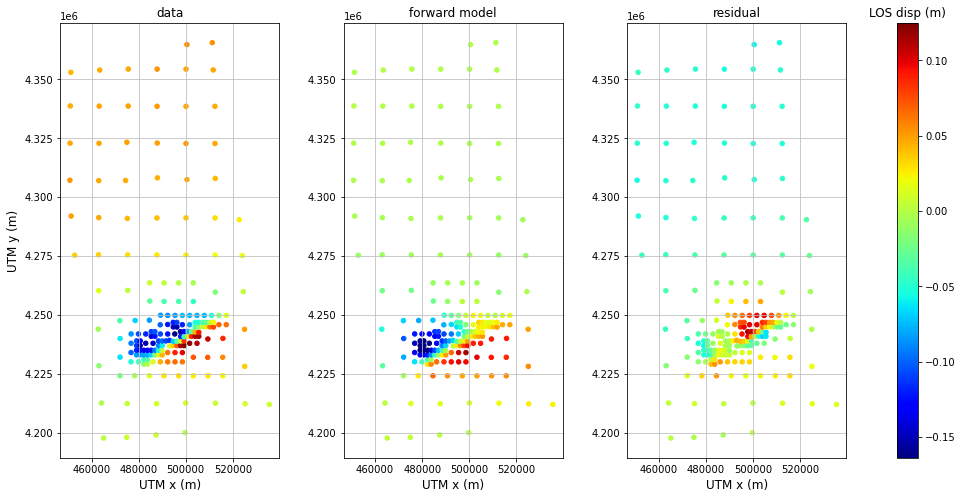

In [21]:
# calculate the residual without nuisances...
shifted_data = data[:,2]-zero_shift
residual_los_disps = model_los_disps-shifted_data

# color limits based on the shifted data
cmin, cmax = shifted_data.min(), shifted_data.max()

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
axlist = [ax1,ax2,ax3]   # handles for your subplots


# scatter with colormap mapping to z value
scat=ax1.scatter(data[:,0],data[:,1],s=20,c=shifted_data, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax1.set_xlabel("UTM x (m)",fontsize=12)
ax1.set_ylabel("UTM y (m)",fontsize=12)
ax1.title.set_text('data')
ax1.grid(True,linestyle='-',color='0.75')
ax1.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax2.scatter(data[:,0],data[:,1],s=20,c=model_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax2.set_xlabel("UTM x (m)",fontsize=12)
ax2.title.set_text('forward model')
ax2.grid(True,linestyle='-',color='0.75')
ax2.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax3.scatter(data[:,0],data[:,1],s=20,c=residual_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax3.set_xlabel("UTM x (m)",fontsize=12)
ax3.title.set_text('residual')
ax3.grid(True,linestyle='-',color='0.75')
ax3.set_aspect('equal')

clb=fig.colorbar(scat,ax=axlist)
clb.ax.set_title('LOS disp (m)')

plt.show();